# Importing necessary package

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

np.set_printoptions(suppress=True)

from __Function__ import *

np.random.seed(42)

# Importing Data

In [2]:
path = r'C:\Users\baris\Desktop\Master Thesis\1. Python\Data\Option_Calibration_SPX_18072025_WMC.csv'
df = pd.read_csv(path, index_col=None)
spx_price = 6296.79

# Calibration of the Weighted Monte Carlo under BS model 

In [3]:
S0 = spx_price  # Data from 18 july 2025
r = 0.0408      # Data from 18 july 2025
T_max = np.max(df['Maturity'].to_numpy('float'))
market_prices = df['Price'].to_numpy('float')
strikes = df['Strike'].to_numpy('float')
average_IV = df['IV'].mean()

In [4]:
average_IV

np.float64(0.14159604913333332)

In [5]:
dates = sorted(set(df['Maturity'])) # Sort maturity 
dates_day = np.array([int(np.ceil(date * 252)) for date in dates]) # Convert the maturity to number of steps

dt = 1/252 # Amplitude of step
N_paths = 50_000 # Number of path
N_steps = int(np.ceil(T_max / dt)) # Max number of needed step

In [6]:
def monte_carlo_path(S0, r, sigma, N_paths, N_steps): 
    Z = np.random.randn(N_paths, N_steps+1)
    paths = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    return np.array(S0*np.exp(np.cumsum(paths,axis=1)))

In [7]:
simulated_prices = monte_carlo_path(S0, r, average_IV, N_paths, N_steps)
discount_factor = np.exp(-r*np.array(dates))      # The discount factor for different maturity

g=np.array(np.zeros(shape=(N_paths, len(df))))    # initialize payoff matrix (V x N) 
C=np.zeros(shape=(len(df)))                       # Price vector (N)

In [8]:
# Calculate the PV of payoffs for all the instruments
time_list = sorted(set(df['Maturity']))

for i, row in enumerate(df.values):
    time_index = time_list.index(row[0])
    date_index = dates_day[time_index]
    if df['Strike'][i] == 0:
        g[:, i] = (row[2] - simulated_prices[:, date_index]) * discount_factor[time_index]
        C[i]=row[1] 
    else:
        g[:, i] = np.maximum((simulated_prices[:, date_index] - row[1]), 0) * discount_factor[time_index]
        C[i]=row[2]

In [9]:
# Check of the shape, we need (V x N) and (N)
print("payoff:", g.shape)
print("market_prices:", np.array(market_prices).shape)

payoff: (50000, 36)
market_prices: (36,)


In [10]:
# Normalisation
g_normalize = g / spx_price
C_normalize = C / spx_price

In [11]:
w = WMC(g_normalize, C_normalize)
w.solve(options={'maxiter': 1e6, 'ftol': 1e-12}, e=1e-5, fPrime=True)
w.opt_result

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 10.353984174466175
        x: [-2.520e+01  3.752e+01 ...  1.194e+01 -2.371e+00]
      nit: 126
      jac: [ 1.868e-06 -2.483e-06 ... -7.303e-06 -5.152e-06]
     nfev: 143
     njev: 143
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>

In [12]:
WMC_lambda = w.lambda_ # Store lambda values
WMC_weights = np.array(w.p).flatten() # Store optimal weights

In [13]:
g_WMC = np.array(np.zeros(shape=(N_paths, len(df))))  
C_WMC = np.zeros(shape=(len(df)))

In [14]:
# Calculate the PV of payoffs for all the instruments with the WMC calibration
time_list = sorted(set(df['Maturity']))

for i, row in enumerate(df.values):
    time_index = time_list.index(row[0])
    date_index = dates_day[time_index]
    if df['Strike'][i] == 0:
        g_WMC[:, i] = (simulated_prices[:, date_index] * WMC_weights).sum()
        C_WMC[i] = g_WMC[:, i].mean()
    else:
        g_WMC[:, i] = np.maximum(((simulated_prices[:, date_index] - row[1]) * WMC_weights), 0).sum() * discount_factor[time_index]
        C_WMC[i] = g_WMC[:, i].mean()

In [15]:
df['WMC_BS'] = C_WMC
df['Error'] = abs((df['WMC_BS'] - market_prices))

In [16]:
df['Error'].mean(), df['Error'].median()

(np.float64(1.0148824411609176), np.float64(0.7224782433177381))

# Summary of the Weighted Monte Carlo Calibration under BS 

In [17]:
# Import the full data to compare how good is our calibrated BS model
path = r'C:\Users\baris\Desktop\Master Thesis\1. Python\Data\Option_Data_SPX_18072025.csv'  
df_pricing = pd.read_csv(path, index_col=None)[['Maturity', 'Strike', 'Price']] 

In [18]:
strikes_pricing = df_pricing['Strike'].to_numpy('float')
maturity_pricing = df_pricing['Maturity'].to_numpy('float')

dates = sorted(set(df_pricing['Maturity']))
discount_factor = np.exp(-r*np.array(dates)) 

In [19]:
g_WMC = np.array(np.zeros(shape=(N_paths, len(df_pricing))))    # initialize payoff matrix  (V x N) 
C_WMC = np.zeros(shape=(len(df_pricing)))                       # initialize price vector (N)

In [20]:
# Calculate the PV of payoffs for all the instruments
time_list = sorted(set(df_pricing['Maturity']))
dates_day = np.array([int(np.ceil(date * 252)) for date in dates])

for i, row in enumerate(df_pricing.values):
    time_index = time_list.index(row[0])
    date_index = dates_day[time_index]
    g_WMC[:, i] = np.maximum(((simulated_prices[:, date_index] - row[1]) * WMC_weights), 0).sum() * discount_factor[time_index]
    C_WMC[i]= g_WMC[:, i].mean()

In [21]:
df_pricing['WMC_BS_Price'] = C_WMC
df_pricing['Error'] = abs((C_WMC - df_pricing['Price']))

In [22]:
maturity_error = Comparaison.comparaison_maturity(df_pricing)
maturity_error

,Metric Maturity,Mean Eror (abs)
0,"Mean (Filtered for maturity < 0.3, Price = 143...",4.6443
1,"Mean (Filtered for maturity >= 0.3 and < 0.6, ...",4.9590
2,"Mean (Filtered for maturity >= 0.6, Price = 35...",7.2572


In [23]:
strike_error = Comparaison.comparaison_strike(df_pricing, spx_price)
strike_error

,Metric Strike,Mean Eror (abs)
0,"Mean (Filtered for strike < 100, Price = 357.6...",8.8014
1,"Mean (Filtered for strike >= 100 and < 105, Pr...",4.0792
2,"Mean (Filtered for strike >= 105, Price = 75.9...",2.1464


In [24]:
surface_error = Comparaison.comparaison_surface(df_pricing)
surface_error

,Metric Surface,Mean Eror (abs)
0,"Mean (Filtered for price < 81.70$, 20% Quantile)",2.3496
1,"Mean (Filtered for price > 81.70$, 20% Quantile)",6.0888
2,"Mean (Filtered for price > 214.65$, 50% Quantile)",7.8715
3,"Mean (Filtered for price > 370.98$, 80% Quantile)",9.1073
4,Mean,5.3103
5,Median,2.7789


In [25]:
N = len(WMC_weights)
u = np.full(N, 1/N)
D_pu = np.sum(WMC_weights * np.log((WMC_weights + 1e-16) / u))
print("Relative entropy D(p||u):", D_pu)

alpha = 1 - D_pu / np.log(N)
print("Alpha :", alpha)

nu_star = N**alpha
print("Nombre effectif de paths nu* :", nu_star)
print("Fraction du total :", nu_star / N)

Relative entropy D(p||u): 0.3802033043192813
Alpha : 0.9648603423910175
Nombre effectif de paths nu* : 34186.119568300805
Fraction du total : 0.6837223913660161


In [26]:
df_stats = Comparaison.stats_weights(WMC_weights)
df_stats

,Statistic,Value
0,Mean,2e-05
1,Standard Error,9.69825e-08
2,Median,1.41753e-05
3,Mode,1.66453e-08
4,Standard Deviation,2.16859e-05
5,Sample Variance,4.7028e-10
6,Kurtosis,145.133
7,Skewness,7.32916
8,Range,0.000800237
9,Minimum,1.66453e-08


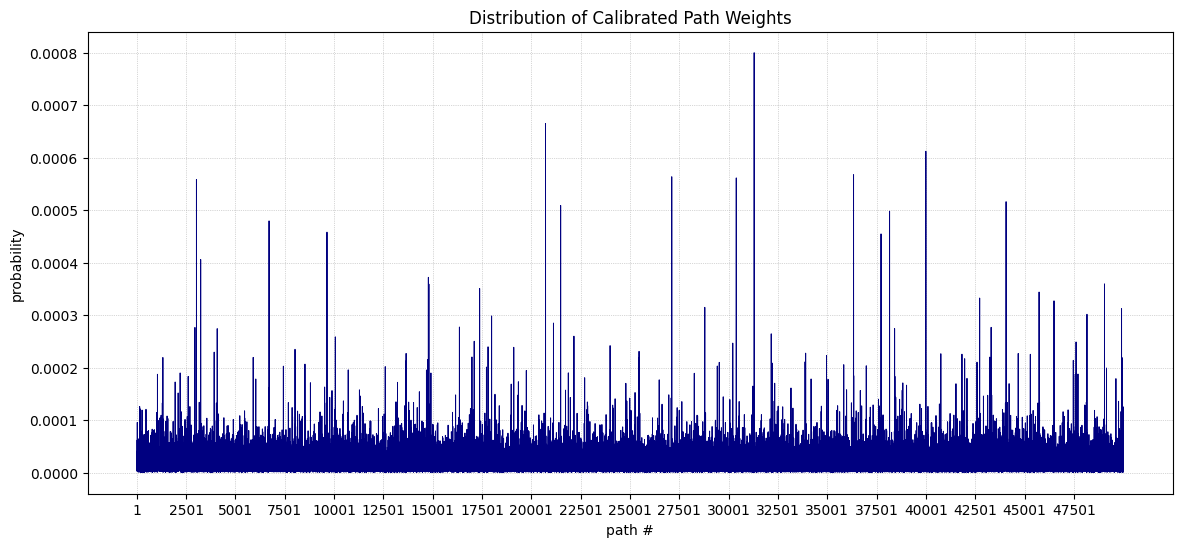

In [27]:
N = len(WMC_weights)
x = np.arange(1, N+1)

plt.figure(figsize=(14, 6))
plt.plot(x, WMC_weights, color='navy', linewidth=0.7)
plt.xlabel('path #')
plt.ylabel('probability')
plt.title('Distribution of Calibrated Path Weights')

tick_spacing = max(1, N // 20)

plt.xticks(np.arange(1, N+1, tick_spacing))
plt.grid(True, linestyle=':', linewidth=0.5)
plt.savefig(r"C:\Users\baris\Desktop\Master Thesis\2. Writing\BS\WMC_BS_distribution_weights.png", dpi=300, bbox_inches='tight')

In [28]:
Comparaison.saving_data(maturity_error, 'BS\WMC_BS_maturity_error')
Comparaison.saving_data(strike_error, 'BS\WMC_BS_strike_error')
Comparaison.saving_data(surface_error, 'BS\WMC_BS_surface_error')
Comparaison.saving_data(df_stats, 'BS\WMC_BS_recap_stat')